In [2]:
import cv2
import mahotas
import matplotlib.pyplot as plt
import numpy as np
import skopt
import warnings

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV
from skopt.plots import plot_objective

In [3]:
# Source: https://github.com/credo-science/CREDO-ML/blob/main/offline_trigger/Wavelet_BINARY_ALFA.ipynb
def loadData(path, verbose=True):

  import cv2
  import glob

  dots = []
  lines = []
  worms = []
  artefacts = []

  for img in glob.glob(path+"hits_votes_4_Dots/*.png"):
      n = cv2.imread(img)
      dots.append(n)
  target_dots = ['dots' for _ in dots]

  for img in glob.glob(path+"hits_votes_4_Lines/*.png"):
      n = cv2.imread(img)
      lines.append(n)
  target_lines = ['lines' for _ in lines]

  for img in glob.glob(path+"hits_votes_4_Worms/*.png"):
      n = cv2.imread(img)
      worms.append(n)
  target_worms = ['worms' for _ in worms]

#   for img in glob.glob(path+"artefacts/*.png"):
#       n = cv2.imread(img)
#       artefacts.append(n)
#   target_artefacts = [3 for _ in artefacts]

  images=dots+lines+worms#+artefacts

  #target_signals_binary = [0 for _ in (dots+lines+worms)]
  #target_artefacts_binary = [1 for _ in artefacts]

  #targets=target_signals_binary+target_artefacts_binary
  targets=target_dots+target_lines+target_worms#+target_artefacts

  if verbose:
    print(len(images),len(targets))
    print(images[0].shape)
    print(len(dots), len(lines), len(worms), len(artefacts))


  return (images, targets)

In [4]:
def pca_reduction(X: np.ndarray, n_components: int, verbose: bool = True):
    """Function for Principal Component Analysis (PCA).

    Args:
        X (np.ndarray): Input data.
        n_components (int): Number of components for PCA reduction.
        verbose (bool): When True print sum of explained variance ratio.

    Returns:
        ret (np.ndarray): Data after PCA.
    """
    X_norm = preprocessing.normalize(X)

    pca = PCA(n_components=n_components)
    pca.fit(X_norm)

    ret = pca.transform(X_norm)

    if verbose:
        print(f'Sum of explained variance ratio: {pca.explained_variance_ratio_.sum()}')

    return ret

In [5]:
def preprocess_data(X: list, blur_ksize: tuple, thresh_min: int, thresh_max: int, zernike_radius: int, zernike_degree: int, pca_num_components: int, pca_verbose: bool) -> np.ndarray:
    """Preprocess data.

    Args:
        X (list): Input data.
        blur_ksize (tuple): Blur kernel size.
        thresh_min (int): Threshold minimal value.
        thresh_max (int): Threshold maximal value.
        zernike_radius (int): Zernike moments radius.
        zernike_degree (int): Zernike moments degree.
        pca_num_components (int): Number of components for PCA reduction.
        pca_verbose (bool): When True PCA prints sum of explained variance ratio.

    Returns:
        ret (np.ndarray): Preprocessed data.
    """
    dim: int = mahotas.features.zernike_moments(
        cv2.cvtColor(X[0], cv2.COLOR_RGB2GRAY), zernike_radius, zernike_degree
        ).shape[0]
    
    ret: np.ndarray = np.zeros((len(X), dim))
    for i in range(len(X)):

        # Preprocess image before extracting zernike moments
        img: np.ndarray = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
        img = cv2.GaussianBlur(img, blur_ksize, 0)
        _, img = cv2.threshold(img, thresh_min, thresh_max, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Extract zernike moments
        zernike: np.ndarray = mahotas.features.zernike_moments(img, zernike_radius, zernike_degree)
        
        ret[i,:] = zernike
    
    # PCA dimensionality reduction
    ret = pca_reduction(ret, pca_num_components, pca_verbose)
        
    return ret

In [6]:
def plotConfusionMatrix(y_test, y_pred, model):
    """Function for displaying confusion matrix

    Args:
        y_test (list): Target classes.
        y_pred (list): Predicted classes.
        model (ClassifierMixin): Model used for prediction.
    """
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

In [7]:
path="../data/hit-images-final/"

X_, y = loadData(path, False)

In [8]:
blur_ksize = (5, 5)
thresh_min = 0
thresh_max = 255 
zernike_radius = 30 
zernike_degree = 28
pca_num_components = 8
pca_verbose = True

X = preprocess_data(X_, blur_ksize, thresh_min, thresh_max, zernike_radius, zernike_degree, pca_num_components, pca_verbose)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Sum of explained variance ratio: 0.9377061093371145


## SVM

In [16]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
opt = BayesSearchCV(
    SVC(), 
    {
        'C': [1.0, 100, 1e-6, 1e+6,],
        'gamma': [1e-6, 1e+1, 'log-uniform'],
        'degree': [1, 3, 8],
        'kernel': ['linear', 'poly', 'rbf'],
    },
    n_iter = 100,
    cv = 5,
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9512690355329949
test. score 0.9190283400809717
best params OrderedDict([('C', 100.0), ('degree', 8), ('gamma', 2.8471376735224263), ('kernel', 'rbf')])


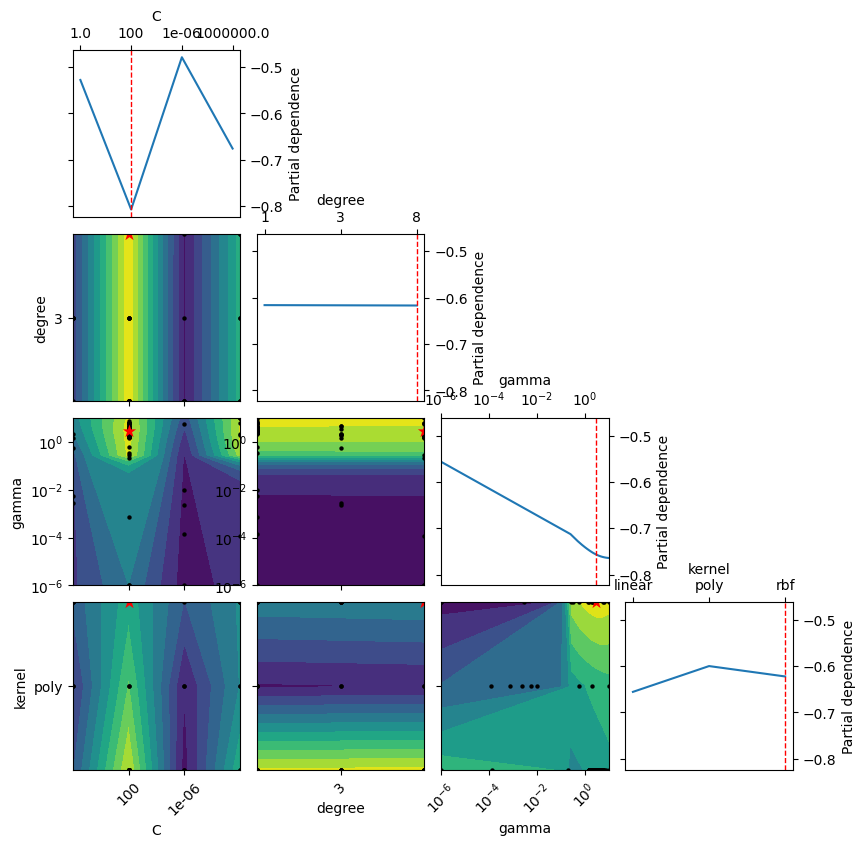

In [17]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

Training accuracy: 0.966497461928934
Test accuracy: 0.9190283400809717


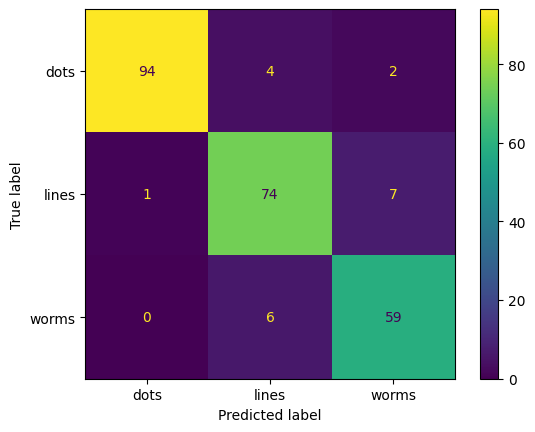

In [18]:
svc = SVC(**opt.best_params_)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
train_accuracy = accuracy_score(y_train, svc.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plotConfusionMatrix(y_test, y_pred, svc)

In [19]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
opt = BayesSearchCV(
    KNeighborsClassifier(), 
    {
        "n_neighbors": (3, 5, 7, 9, 11),
        "weights": ["uniform", "distance"],
        "algorithm": [ "ball_tree", "kd_tree", "brute"],
        "p": (1,2),
        "leaf_size": (10, 20, 30, 40, 50)
    },
    n_iter = 100,
    cv = 5
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9299492385786803
test. score 0.9068825910931174
best params OrderedDict([('algorithm', 'brute'), ('leaf_size', 50), ('n_neighbors', 3), ('p', 2), ('weights', 'distance')])


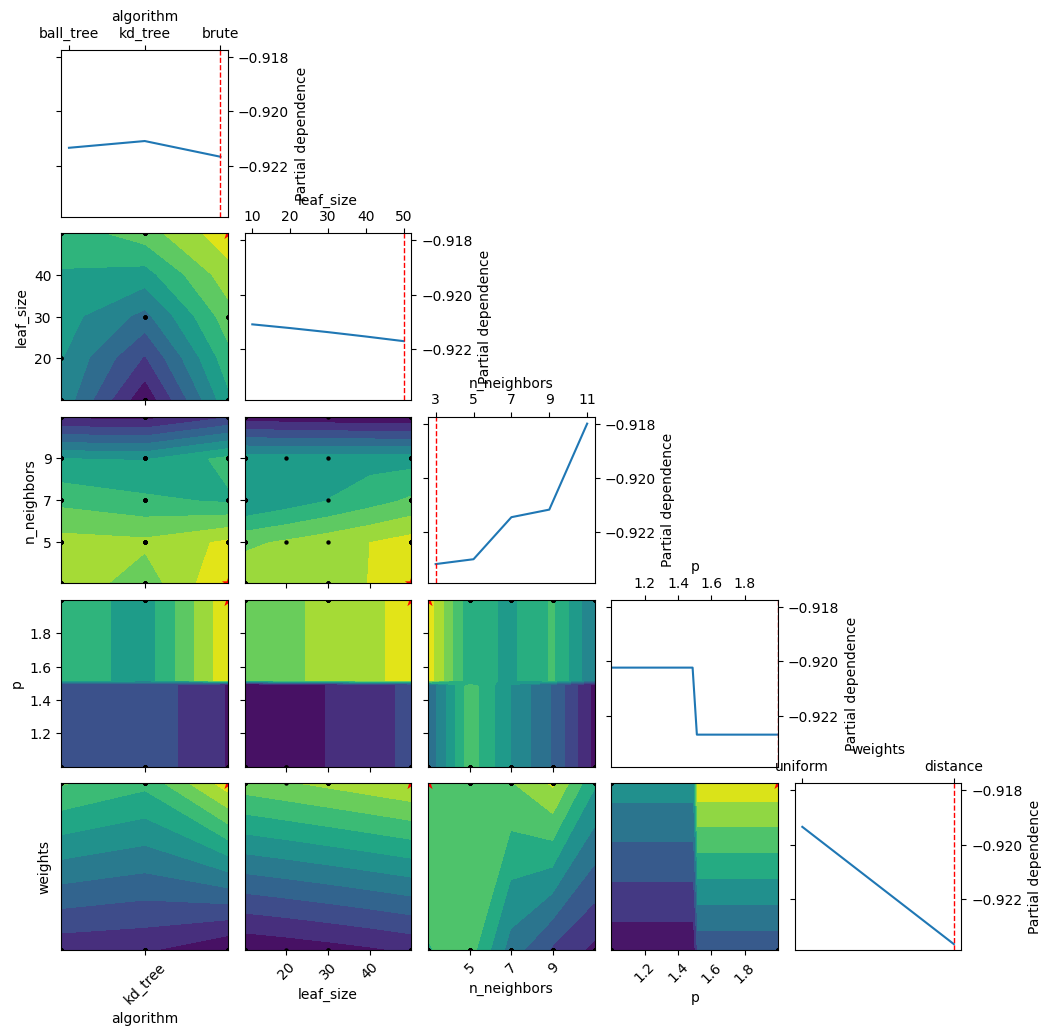

In [20]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

# RFC

In [11]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
opt = BayesSearchCV(
    RandomForestClassifier(), 
    {
        'n_estimators': (10, 50, 100, 200),
        'criterion': ['gini', 'entropy'],
        'max_features': ["sqrt", "log2", None],
    },
    n_iter = 100,
    cv = 5,
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9411167512690357
test. score 0.9311740890688259
best params OrderedDict([('criterion', 'entropy'), ('max_features', 'sqrt'), ('n_estimators', 100)])


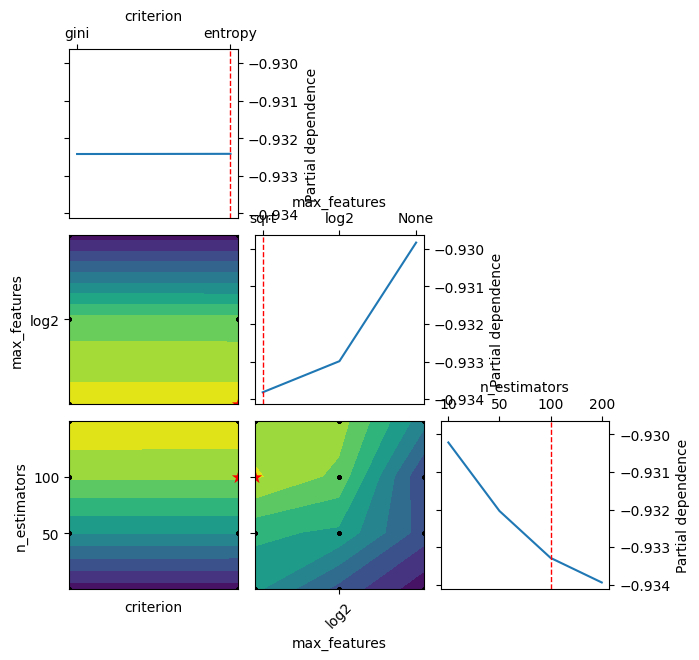

In [12]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

# MLP

In [10]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
warnings.filterwarnings('ignore', message='.*converge.*')
opt = BayesSearchCV(
    MLPClassifier(max_iter=1000), 
    {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [1e-5, 1e-4, 1e-3],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
    },
    n_iter = 100,
    cv = 5,
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9411167512690355
test. score 0.9109311740890689
best params OrderedDict([('activation', 'relu'), ('alpha', 0.001), ('learning_rate', 'invscaling'), ('solver', 'adam')])


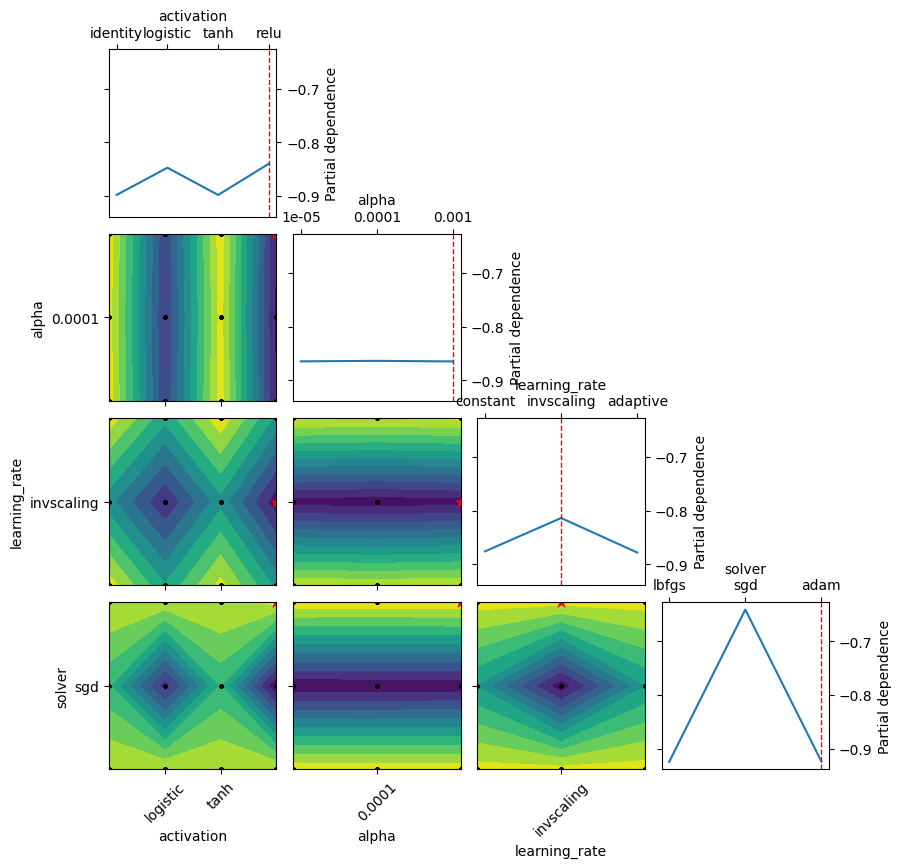

In [11]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

Training accuracy: 0.9583756345177665
Test accuracy: 0.9109311740890689


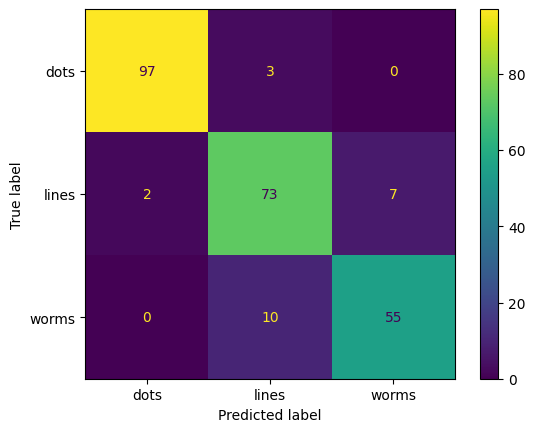

In [12]:
mlp = MLPClassifier(**opt.best_params_, max_iter=1000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
train_accuracy = accuracy_score(y_train, mlp.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plotConfusionMatrix(y_test, y_pred, mlp)